## Stock Price Prediction with Sentiment Analysis

In [1]:
# !pip install charset-normalizer

In [2]:
# To reload the imported modules automatically
%load_ext autoreload
%autoreload 2

In [3]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
import os

# Import modules
import config as cfg
import data_processing as dp
import sentiment_analysis as sa
import model as mdl
import utils as ut

/opt/anaconda3/envs/tf_metal/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
os.makedirs(cfg.DATASET_DIR, exist_ok=True)

### Load and Analyze News Data

In [5]:
sentiment_csv_path = f"{cfg.DATASET_DIR}/{cfg.STOCK_SYMBOL}_daily_sentiment.csv"

if cfg.UPDATE_SENTIMENT_CSV or not os.path.exists(sentiment_csv_path):
    print("Generating new sentiment data and saving to CSV...")
    news_df = dp.load_and_analyze_news_data(cfg.NEWS_DATA_FILE, cfg.STOCK_SYMBOL)
    company_sentiment_df = sa.process_news_sentiment(news_df, cfg.STOCK_SYMBOL)
    daily_sentiment_df = sa.aggregate_daily_sentiment(company_sentiment_df)
    ut.save_dataframe(daily_sentiment_df, sentiment_csv_path)
else:
    print(f"Loading existing sentiment data from {sentiment_csv_path}...")
    daily_sentiment_df = pd.read_csv(sentiment_csv_path, index_col='Date', parse_dates=True)

print("Sentiment data ready.")

Generating new sentiment data and saving to CSV...
Loading and selecting news data...
🎯 Selected target stock: NVDA (3133 articles)
\n📰 Processing news sentiment for NVDA...
Initializing sentiment analyzer with model: ProsusAI/finbert
Using device: cpu
Analyzer initialized successfully.
Analyzing 3133 headlines in batches of 32...


  0%|          | 0/98 [00:00<?, ?it/s]

\nSentiment distribution:\n Sentiment
neutral     1573
positive     887
negative     673
Name: count, dtype: int64
\n📊 Aggregating daily sentiment scores...
DataFrame saved to Dataset/NVDA_daily_sentiment.csv
Sentiment data ready.


### Fetch Stock Data and Calculate Technical Indicators

In [6]:
START_DATE, END_DATE = ut.calculate_dynamic_date_range(daily_sentiment_df)

stock_filename = f"{cfg.STOCK_SYMBOL}_stock_data_{START_DATE}_to_{END_DATE}.csv"
stock_csv_path = os.path.join(cfg.DATASET_DIR, stock_filename)

if cfg.UPDATE_STOCK_CSV or not os.path.exists(stock_csv_path):
    print(f"Fetching new stock data from yfinance ({START_DATE} to {END_DATE})...")
    stock_data = dp.fetch_stock_data(cfg.STOCK_SYMBOL, START_DATE, END_DATE)
    if stock_data is not None:
        stock_data.to_csv(stock_csv_path)
        print(f"Stock data saved to {stock_csv_path}")
else:
    print(f"Loading existing stock data from {stock_csv_path}...")
    stock_data = pd.read_csv(stock_csv_path, index_col='Date', parse_dates=True)

# Calculate technical indicators from the loaded/fetched data
tech_data = dp.calculate_technical_indicators(stock_data)
print("Technical indicators calculated.")

Fetching new stock data from yfinance (2010-03-03 to 2020-06-10)...
\n📈 Fetching stock data for NVDA...
Successfully fetched 2586 days of data.
Stock data saved to Dataset/NVDA_stock_data_2010-03-03_to_2020-06-10.csv
Technical indicators calculated.


### Prepare data for technical models

In [7]:
X_train_tech, X_test_tech, y_train_tech, y_test_tech, scaler_tech = mdl.prepare_data_for_lstm(
    tech_data, cfg.BASELINE_FEATURES, cfg.BASELINE_TARGET, cfg.SEQUENCE_LENGTH, cfg.TEST_SIZE
)

### Prepare Data for Single Layer LSTM Model

In [8]:
print("\\n--- Running LSTM Model (Single-Layer) ---")
baseline_model = mdl.build_single_layer_lstm((X_train_tech.shape[1], X_train_tech.shape[2]))
baseline_model.summary()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=1)
baseline_history = baseline_model.fit(
    X_train_tech, y_train_tech, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr], verbose=1
)

\n--- Running LSTM Model (Single-Layer) ---


2025-07-25 15:48:11.935755: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-25 15:48:11.935793: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-25 15:48:11.935801: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753454891.935811  233707 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753454891.935834  233707 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,249 (270.50 KB)

 Trainable params: 69,249 (270.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-07-25 15:48:12.348893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0193 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0045 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0036 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0034 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0034 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 10/20
50/52 ━━━━━━━━━━━━

#### Evaluate Baseline Model

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Plot saved to Output/NVDA_Single-Layer_LSTM_analysis.png


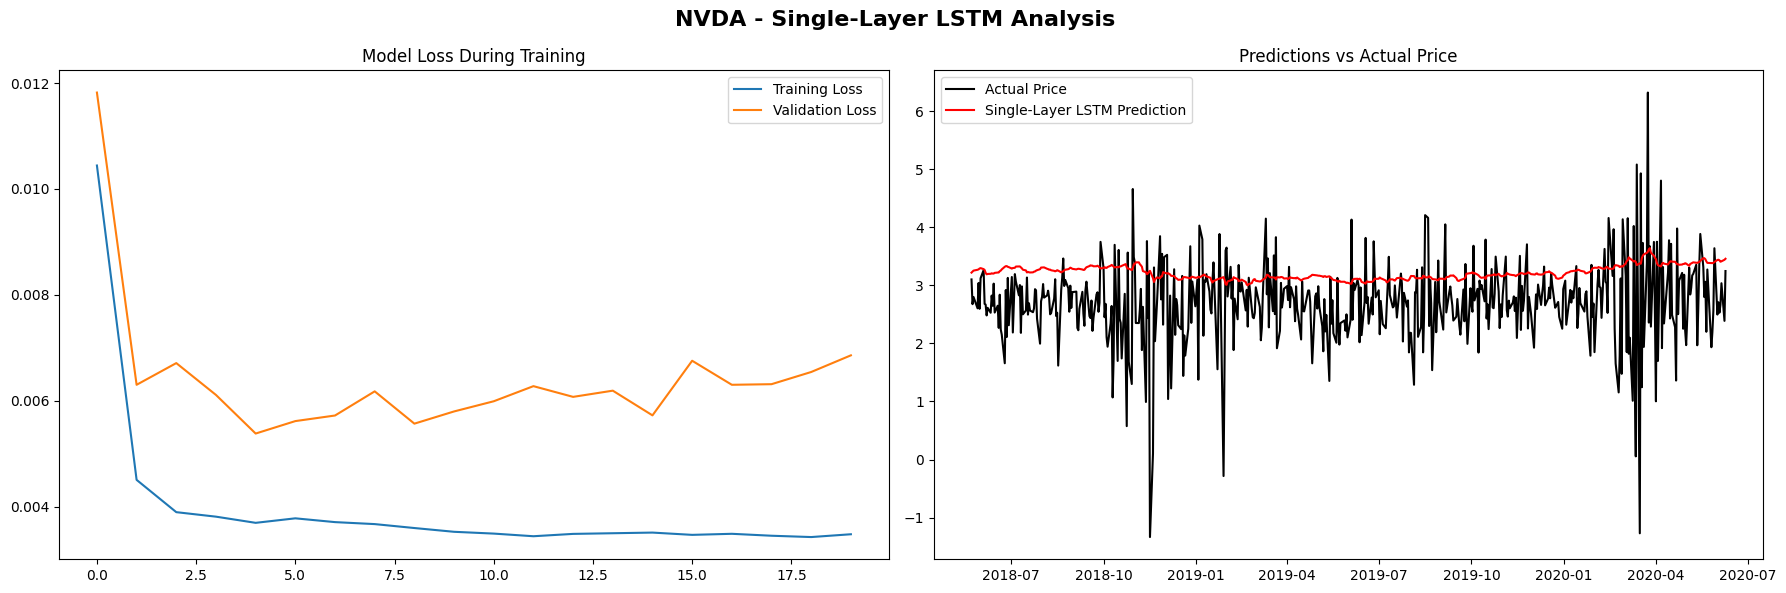

In [9]:
base_preds = baseline_model.predict(X_test_tech)
close_scaler = MinMaxScaler().fit(tech_data[['Close']])
y_test_tech_scaled = close_scaler.inverse_transform(y_test_tech.reshape(-1, 1))
base_preds_scaled = close_scaler.inverse_transform(base_preds)
baseline_metrics = ut.calculate_metrics(y_test_tech_scaled, base_preds_scaled, 'Single-Layer LSTM')
test_dates_tech = tech_data.index[-len(y_test_tech_scaled):]
ut.plot_model_results(baseline_history, y_test_tech_scaled, base_preds_scaled, test_dates_tech, cfg.STOCK_SYMBOL,
                      'Single-Layer LSTM')

### Multi-Layer LSTM Model

In [10]:
print("\\n--- Running Multi-Layer Model ---")
multi_layer_model = mdl.build_multi_layer_lstm((X_train_tech.shape[1], X_train_tech.shape[2]))
multi_layer_model.summary()
multi_layer_history = multi_layer_model.fit(
    X_train_tech, y_train_tech, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr], verbose=1
)

\n--- Running Multi-Layer Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 7, 128)         │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,179 (469.45 KB)

 Trainable params: 120,179 (469.45 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0176 - val_loss: 0.0107 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0033 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0032 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0032 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0032 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0030 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 10/20
52/52 ━

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Plot saved to Output/NVDA_Multi-Layer_LSTM_analysis.png


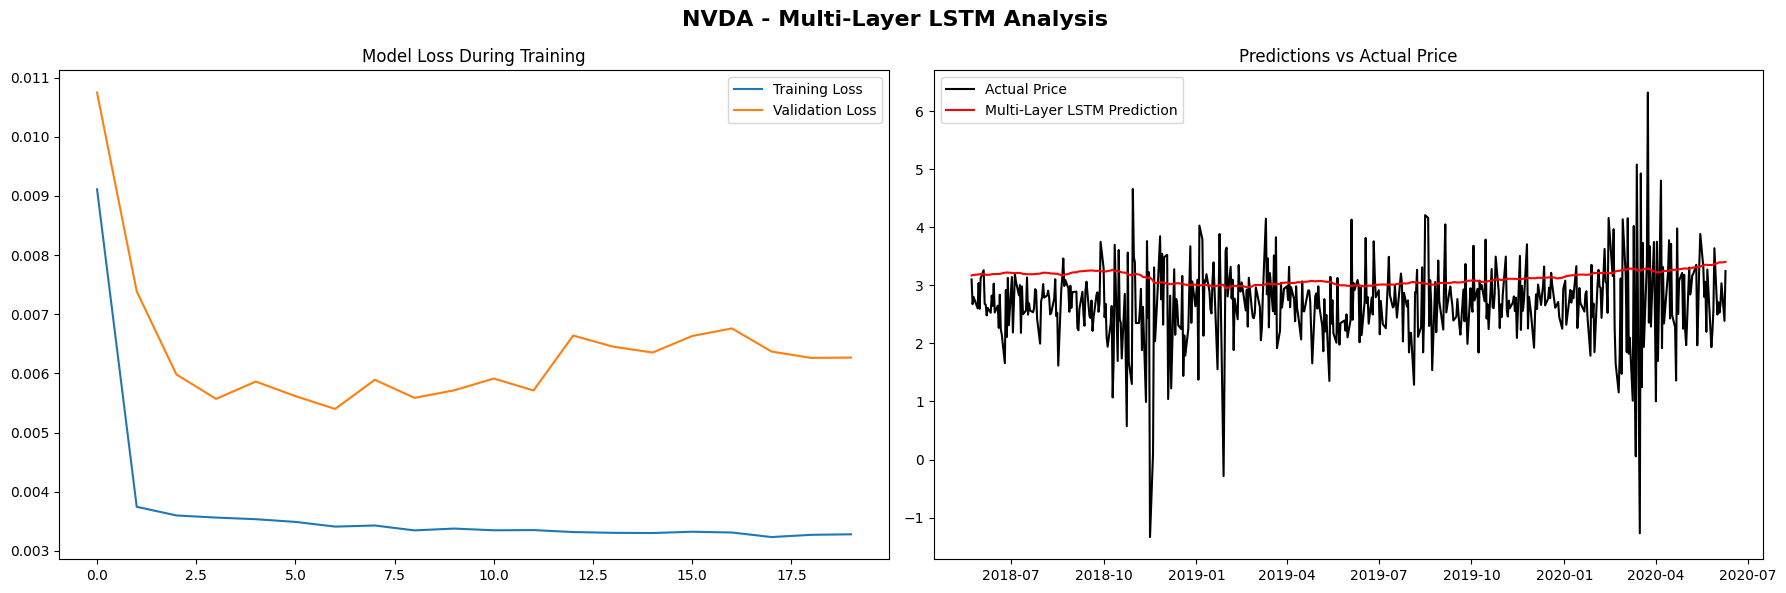

In [11]:
multi_preds = multi_layer_model.predict(X_test_tech)
multi_preds_scaled = close_scaler.inverse_transform(multi_preds)
multi_layer_metrics = ut.calculate_metrics(y_test_tech_scaled, multi_preds_scaled, 'Multi-Layer LSTM')
ut.plot_model_results(multi_layer_history, y_test_tech_scaled, multi_preds_scaled, test_dates_tech, cfg.STOCK_SYMBOL, 'Multi-Layer LSTM')

### Sentiment-Enhanced LSTM Model (Single-Layer)

In [12]:
print("\\n--- Running Sentiment-Enhanced Model ---")
enhanced_full_data = dp.create_enhanced_dataset(tech_data, daily_sentiment_df)
X_train_enh, X_test_enh, y_train_enh, y_test_enh, scaler_enh = mdl.prepare_data_for_lstm(
    enhanced_full_data, cfg.ENHANCED_FEATURES, cfg.ENHANCED_TARGET, cfg.SEQUENCE_LENGTH, cfg.TEST_SIZE
)

enhanced_model = mdl.build_single_layer_lstm((X_train_enh.shape[1], X_train_enh.shape[2]))
enhanced_model.summary()

enhanced_history = enhanced_model.fit(
    X_train_enh, y_train_enh, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr], verbose=1
)

\n--- Running Sentiment-Enhanced Model ---
\n🔗 Merging sentiment and technical data...
Enhanced dataset shape: (2573, 16)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 128)            │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,785 (276.50 KB)

 Trainable params: 70,785 (276.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0171 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0042 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0033 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0032 - val_loss: 0.0058 - learning_rate: 0.0010
Epoch 10/20
52/52 ━

#### Evaluate Sentiment-Enhanced Model

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Plot saved to Output/NVDA_Enhanced_LSTM_analysis.png


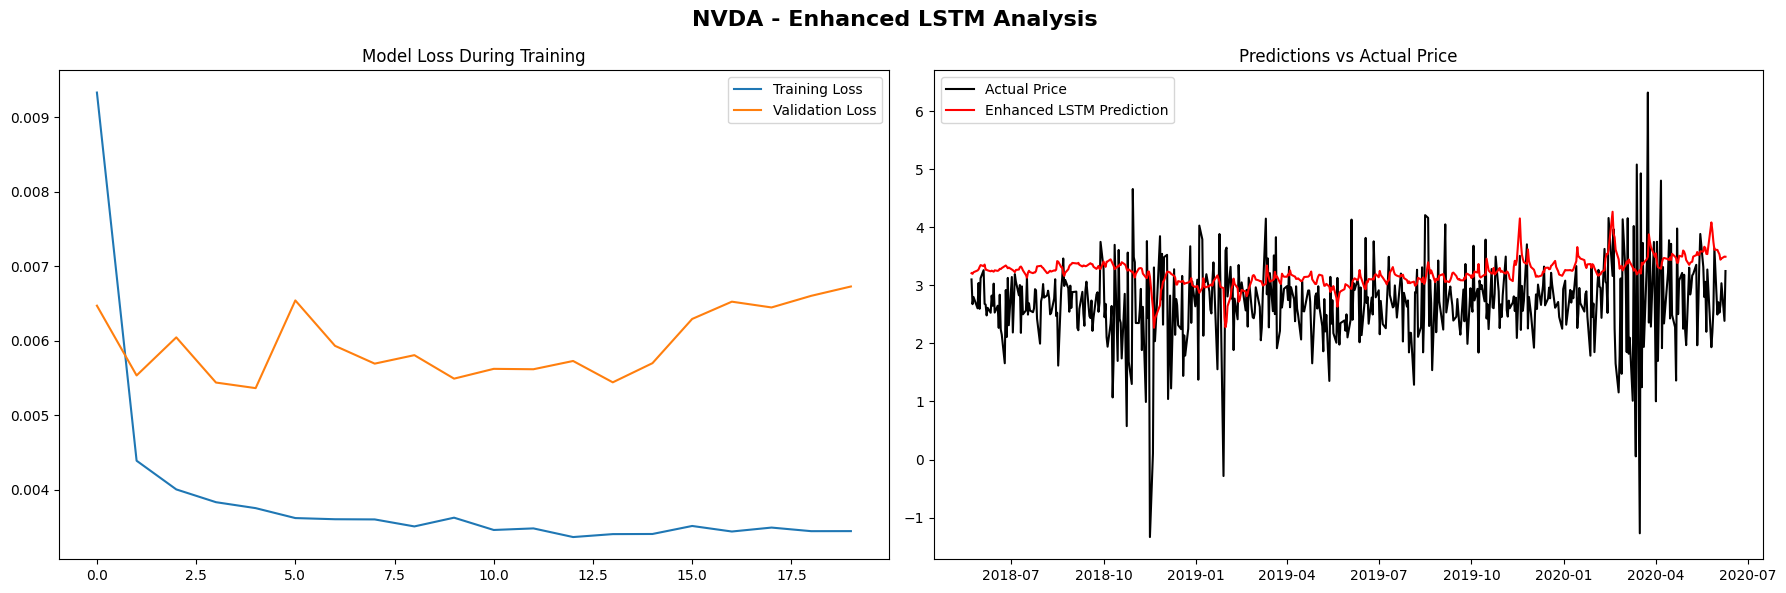

In [13]:
enh_preds = enhanced_model.predict(X_test_enh)
y_test_enh_scaled = close_scaler.inverse_transform(y_test_enh.reshape(-1, 1))
enh_preds_scaled = close_scaler.inverse_transform(enh_preds)
enhanced_metrics = ut.calculate_metrics(y_test_enh_scaled, enh_preds_scaled, 'Enhanced LSTM')
test_dates_enh = enhanced_full_data.index[-len(y_test_enh_scaled):]
ut.plot_model_results(enhanced_history, y_test_enh_scaled, enh_preds_scaled, test_dates_enh, cfg.STOCK_SYMBOL, 'Enhanced LSTM')

### Sentiment-Enhanced LSTM Model (Multi-Layer)

In [14]:
print("\\n--- Running Multi-Layer Enhanced Model ---")
multi_enhanced_model = mdl.build_multi_layer_lstm((X_train_enh.shape[1], X_train_enh.shape[2]))
multi_enhanced_history = multi_enhanced_model.fit(
    X_train_enh, y_train_enh, epochs=cfg.EPOCHS, batch_size=cfg.BATCH_SIZE,
    validation_split=0.2, callbacks=[reduce_lr], verbose=1
)

\n--- Running Multi-Layer Enhanced Model ---
Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0191 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0036 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0035 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0033 - val_loss: 0.0054 - learning_rate: 0.0010
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0031 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0032 - val_loss: 0.0056 - learning_rate: 0.0010
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Plot saved to Output/NVDA_Multi-Layer_Enhanced_LSTM_analysis.png


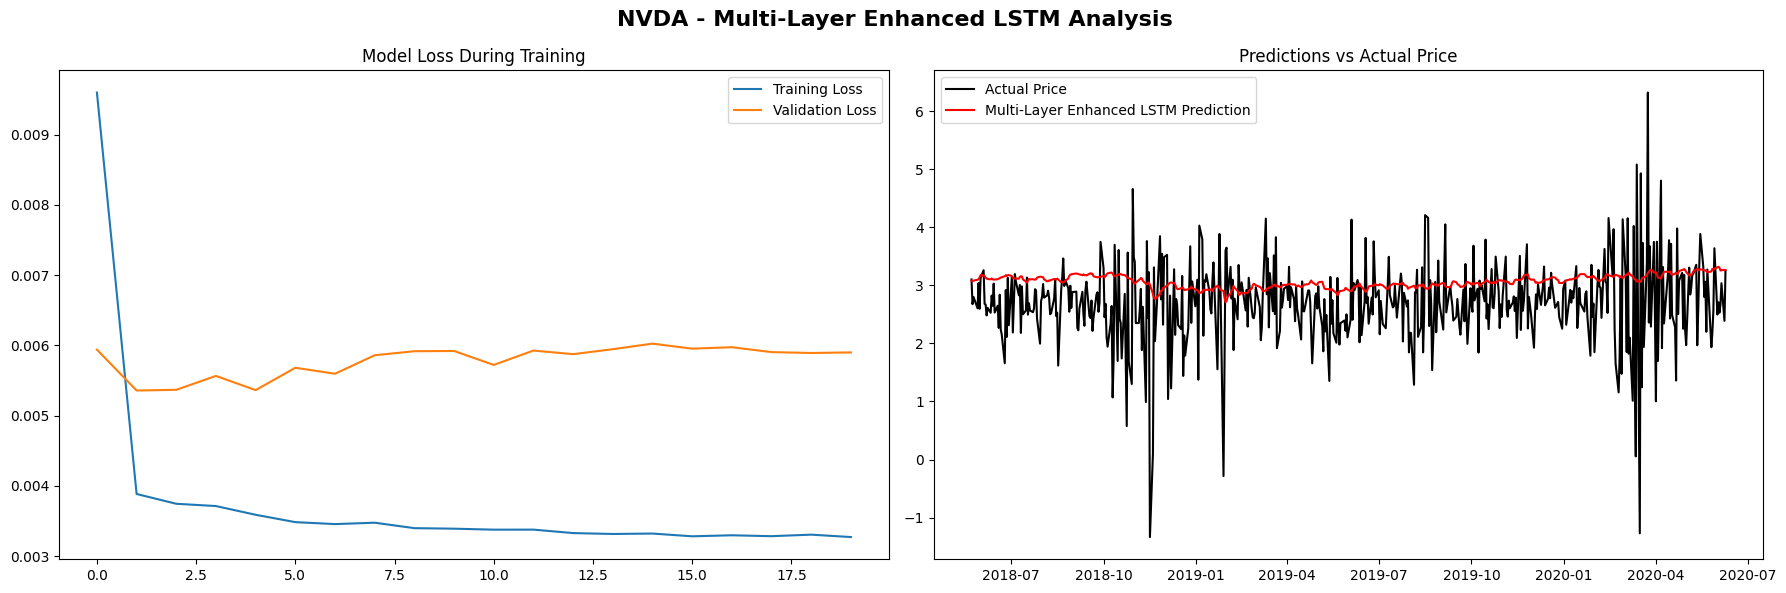

In [15]:
multi_enh_preds = multi_enhanced_model.predict(X_test_enh)
multi_enh_preds_scaled = close_scaler.inverse_transform(multi_enh_preds)
multi_enhanced_metrics = ut.calculate_metrics(y_test_enh_scaled, multi_enh_preds_scaled, 'Multi-Layer Enhanced LSTM')
ut.plot_model_results(multi_enhanced_history, y_test_enh_scaled, multi_enh_preds_scaled, test_dates_enh, cfg.STOCK_SYMBOL, 'Multi-Layer Enhanced LSTM')


### Final Performance Comparison

In [16]:
naive_preds = np.roll(y_test_tech_scaled, 1)
naive_preds[0] = y_test_tech_scaled[0]
naive_metrics = ut.calculate_metrics(y_test_tech_scaled, naive_preds, 'Naive Baseline')

# Performance DataFrame
all_metrics_df = pd.DataFrame([
    naive_metrics,
    baseline_metrics,
    enhanced_metrics,
    multi_layer_metrics,
    multi_enhanced_metrics,
]).round(4)

print("\n📊 COMPREHENSIVE PERFORMANCE COMPARISON")
print("-" * 60)
print(all_metrics_df.to_string(index=False))

# Define which metrics are 'lower is better' vs 'higher is better'
metrics_to_evaluate = {
    'RMSE': 'min',
    'MAE': 'min',
    'Directional_Accuracy': 'max'
}

print("-" * 30)
print("Best Model for Each Metric")
print("-" * 30)

for metric, method in metrics_to_evaluate.items():
    if method == 'min':
        # For RMSE and MAE, the lowest score is the best
        winner_idx = all_metrics_df[metric].idxmin()
    else: # method == 'max'
        # For Directional Accuracy, the highest score is the best
        winner_idx = all_metrics_df[metric].idxmax()

    # Get the row of the winning model
    winner_row = all_metrics_df.loc[winner_idx]

    model_name = winner_row['Model']
    score = winner_row[metric]

    print(f"{metric} : {model_name} (Score: {score:.4f})")


📊 COMPREHENSIVE PERFORMANCE COMPARISON
------------------------------------------------------------
                    Model   RMSE    MAE  Directional_Accuracy
           Naive Baseline 1.0739 0.7357               30.1556
        Single-Layer LSTM 0.8897 0.6756               44.3580
            Enhanced LSTM 0.9137 0.7052               35.6031
         Multi-Layer LSTM 0.8397 0.6239               41.2451
Multi-Layer Enhanced LSTM 0.8086 0.5924               42.4125
------------------------------
Best Model for Each Metric
------------------------------
RMSE : Multi-Layer Enhanced LSTM (Score: 0.8086)
MAE : Multi-Layer Enhanced LSTM (Score: 0.5924)
Directional_Accuracy : Single-Layer LSTM (Score: 44.3580)


In [17]:
ranking_df = all_metrics_df.copy()

ranking_df['RMSE_Rank'] = ranking_df['RMSE'].rank(method='min', ascending=True)
ranking_df['MAE_Rank'] = ranking_df['MAE'].rank(method='min', ascending=True)


ranking_df['DA_Rank'] = ranking_df['Directional_Accuracy'].rank(method='min', ascending=False)

ranking_df['Total_Rank'] = ranking_df['RMSE_Rank'] + ranking_df['MAE_Rank'] + ranking_df['DA_Rank']

final_ranking = ranking_df.sort_values(by='Total_Rank', ascending=True)

print("-" * 40)
print("\\n🏆 Overall Model Ranking (Best to Worst)")
print("-" * 40)
print(final_ranking[['Model', 'Total_Rank', 'RMSE', 'Directional_Accuracy']].reset_index(drop=True).to_string())

----------------------------------------
\n🏆 Overall Model Ranking (Best to Worst)
----------------------------------------
                       Model  Total_Rank    RMSE  Directional_Accuracy
0  Multi-Layer Enhanced LSTM         4.0  0.8086               42.4125
1          Single-Layer LSTM         7.0  0.8897               44.3580
2           Multi-Layer LSTM         7.0  0.8397               41.2451
3              Enhanced LSTM        12.0  0.9137               35.6031
4             Naive Baseline        15.0  1.0739               30.1556


### Plot Results

Plot saved to Output/NVDA_all_models_comparison.png


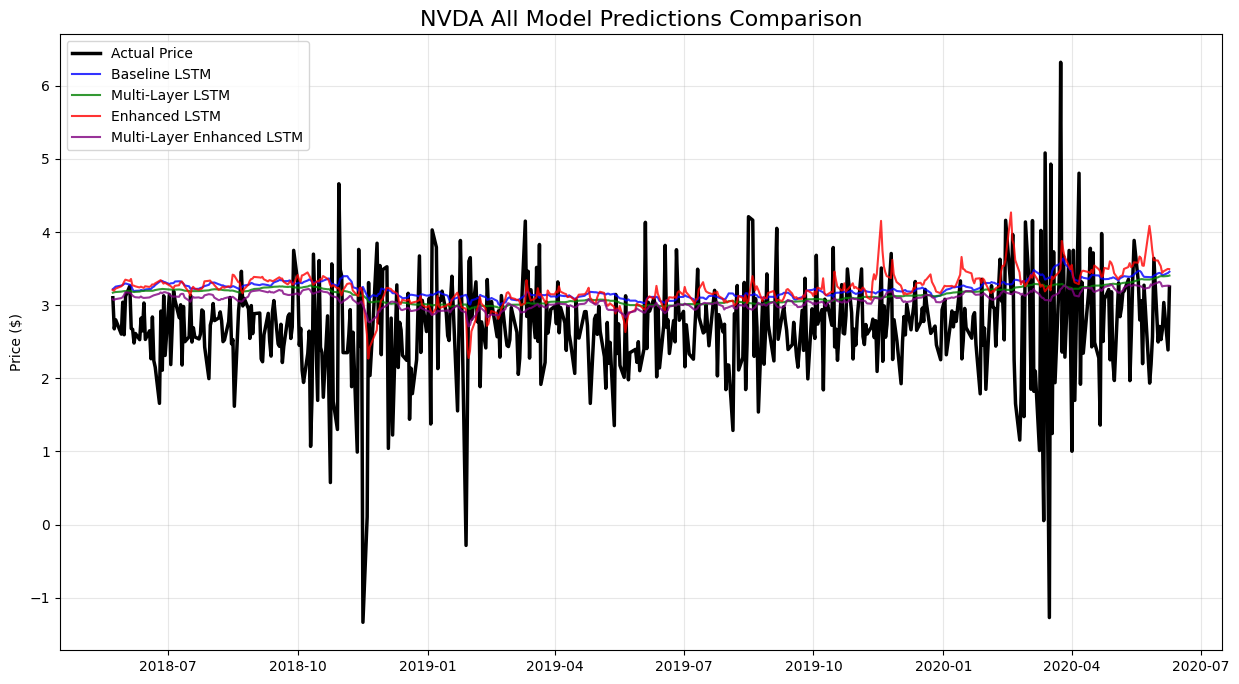

In [18]:
plot_data = {
    'Actual': {'dates': test_dates_tech, 'values': y_test_tech_scaled},
    'Baseline LSTM': {'dates': test_dates_tech, 'values': base_preds_scaled},
    'Multi-Layer LSTM': {'dates': test_dates_tech, 'values': multi_preds_scaled},
    'Enhanced LSTM': {'dates': test_dates_enh, 'values': enh_preds_scaled},
    'Multi-Layer Enhanced LSTM': {'dates': test_dates_enh, 'values': multi_enh_preds_scaled}
}
ut.plot_final_comparison(plot_data, cfg.STOCK_SYMBOL)